In [1]:
import pickle
import sys
import datetime as dt
import itertools as it
from pathlib import Path

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm
import seaborn as sns
from matplotlib import pyplot as plt

import lenskit

from src import paths
from src.datasets import daocensus_text, to_lenskit
from src.model_selection import timeFreqSplitCurrent
from src.utils import Timer

/tmp/ipykernel_1785870/2287164461.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# TODO: Deleteme
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Parameters

In [3]:
ORG_NAME = 'Decentraland'
ORG_PLATFORM: str = 'snapshot'
USE_ORG_NAMES: bool = True

# Evaluation
K_RECOMMENDATIONS: list[int] = [1,3,5,10,100]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_SPLITS = 10 # Use just last 10 splits
CUTOFF_DATE_STR: str = '2023-07-29'

MDF_FILE: str = None

In [4]:
CUTOFF_DATE = dt.datetime.fromisoformat(CUTOFF_DATE_STR) if CUTOFF_DATE_STR else None

print('CUTOFF_DATE', CUTOFF_DATE, type(CUTOFF_DATE))
# Metrics Dataframe
MDF_FILE = Path(MDF_FILE) if MDF_FILE else paths.pln_mdf(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date=CUTOFF_DATE)
print(MDF_FILE)

CUTOFF_DATE 2023-07-29 00:00:00 <class 'datetime.datetime'>
data/pln/mdf_Decentraland_W-THU_normalize-cutoff_date=2023-07-29 00:00:00.pkl


## Getting the dataset

In [5]:
print(ORG_NAME, ORG_PLATFORM, USE_ORG_NAMES, CUTOFF_DATE)
dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES, cutoff_date=CUTOFF_DATE)
dfv[['voter', 'proposal']] = dfv[['voter', 'proposal']].astype(str)
dfp[['id']] = dfp[['id']].astype(str)
dfp = dfp.set_index('id')
print(dfv.info())
print(dfp.info())

Decentraland snapshot True 2023-07-29 00:00:00
Warning, removing 116560 votes without proposal
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116560 entries, 0 to 116559
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       116560 non-null  object        
 1   name           116560 non-null  object        
 2   id             116560 non-null  object        
 3   proposal       116560 non-null  object        
 4   deployment     116560 non-null  object        
 5   platform_vote  116560 non-null  object        
 6   voter          116560 non-null  object        
 7   date           116560 non-null  datetime64[us]
 8   choice         116560 non-null  object        
 9   weight         116560 non-null  float64       
dtypes: datetime64[us](1), float64(1), object(8)
memory usage: 8.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1942 entries, 8d4c918e-c925-55d4-a48d-296476593aa

## Using Item-based KNN

In [7]:
from lenskit.algorithms import item_knn
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k, r_precision_at_k

In [8]:
df = to_lenskit(dfv)
all_folds = list(timeFreqSplitCurrent(
    df, SPLITS_FREQ, dfp.reset_index(), return_open=True, remove_not_in_train_col='user',
    item_col='item',
    user_col='user',
))
folds = all_folds[-LAST_SPLITS:]

In [9]:
metrics_f = { 
    'precision':precision_at_k, 
    'ndcg': ndcg_at_k, 
    'map': map_at_k, 
    'recall': recall_at_k,
    'r-precision': r_precision_at_k,
}

In [10]:
print('nunique train:', folds[0].train['item'].nunique())
print('open props:', len(folds[0].open_proposals))
print('open props in train:', len(np.intersect1d(folds[0].open_proposals, folds[0].train['item'].unique())))
print('nunique test:', folds[0].test['item'].nunique())
print('open props in test:', len(np.intersect1d(folds[0].open_proposals, folds[0].test['item'].unique())))
'360848f6-b447-5540-ba76-a035cff69734' in folds[0].train['item'].unique()

nunique train: 1838
open props: 18
open props in train: 18
nunique test: 18
open props in test: 18


True

In [11]:
folds[0].train[folds[0].train['item'] == '360848f6-b447-5540-ba76-a035cff69734']

,user,item,timestamp,rating
107380,0xc375b0a133f49dbf3c6418895d6d024be2d8f84a,360848f6-b447-5540-ba76-a035cff69734,2023-05-10 22:50:35,1
107383,0x6a43fcce7dec946dc463d4e3cefe436c651f2466,360848f6-b447-5540-ba76-a035cff69734,2023-05-10 17:26:35,1
107390,0x8660c0133a9705ab8ab370c3b4e63b60381bf4b3,360848f6-b447-5540-ba76-a035cff69734,2023-05-10 10:39:54,1
107406,0xdd9a5ca4710fe4b08672fabc2d5774e0926a4afb,360848f6-b447-5540-ba76-a035cff69734,2023-05-09 18:17:01,1
107410,0x70753f5847071ec1c96cb9ebed2b2dbe2846da3a,360848f6-b447-5540-ba76-a035cff69734,2023-05-09 16:25:40,1
...,...,...,...,...
107529,0x4e9f5aa62c28f40bd772fbf7826a0595ec2dbad0,360848f6-b447-5540-ba76-a035cff69734,2023-05-03 03:37:30,1
107530,0xfec447014eb1b96279d7fef62ea3f8848f99d09d,360848f6-b447-5540-ba76-a035cff69734,2023-05-03 03:30:57,1
107531,0xed0e0cb94f60f72ec94bef848f5df4cbd365af1d,360848f6-b447-5540-ba76-a035cff69734,2023-05-03 02:29:10,1
107532,0x88f659b4b6d5614b991c6404b34f821e10390ec0,360848f6-b447-5540-ba76-a035cff69734,2023-05-03 00:14:08,1


In [12]:
from src.utils import testHParamsLenskit

In [13]:
def testHParamsItemKNN(fold, k: int, window_size=None):
    # Create algorithm
    algo = item_knn.ItemItem(
        feedback='implicit', # VERY IMPORTANT
        min_sim=0,
        # min_nbrs=0,
        nnbrs=k,  # the maximum number of neighbors for scoring each item (None for unlimited)
    )
    return testHParamsLenskit(algo, fold, k, window_size)
    
testHParamsItemKNN(0, 5, '14d')

/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
Numba is using threading layer omp - consider TBB
found 1 potential runtime problems - see https://boi.st/lkpy-perf
/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/lenskit/algorithms/item_knn.py:119: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  b = blocks[bi]


{'time': 6.104867404093966,
 'open_proposals': 18,
 'min_recs': 1,
 'avg_recs': 9.795918367346939,
 'precision@1': 0.41836734693877553,
 'precision@3': 0.3537414965986395,
 'precision@5': 0.2816326530612245,
 'precision@10': 0.2010204081632653,
 'precision@100': 0.02612244897959184,
 'ndcg@1': 0.2949640287769784,
 'ndcg@3': 0.3355170230723114,
 'ndcg@5': 0.36015071902018586,
 'ndcg@10': 0.4009555318439043,
 'ndcg@100': 0.46276787885753257,
 'map@1': 0.41836734693877553,
 'map@3': 0.4433106575963719,
 'map@5': 0.4638265306122449,
 'map@10': 0.49638325369830466,
 'map@100': 0.5355471779141068,
 'recall@1': 0.19142371234207967,
 'recall@3': 0.45538143828960154,
 'recall@5': 0.558357628765792,
 'recall@10': 0.7184766763848396,
 'recall@100': 1.0,
 'r-precision@1': 0.4575493612078977,
 'r-precision@3': 0.7181839402427638,
 'r-precision@5': 0.7572776280323449,
 'r-precision@10': 0.7934411500449234,
 'r-precision@100': 0.7934411500449235}

### Exploring hparams

In [14]:
from sklearn.model_selection import ParameterGrid
from src.model_selection import explore_hparams

In [15]:
results = explore_hparams(
    testHParamsItemKNN, 
    ParameterGrid({
    'fold': range(len(folds)),
    'k': [1,2,3,4,5,6,7,8,9,10,15], # ,20,25,30,35,40,45,50,60,70,80,90,100],
    'window_size': ['7d', '14d', '21d', '30d', '90d', '180d', '360d', '10Y'],
    }),
    paths.knn_progress('itemknn', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, CUTOFF_DATE),
)
mdfi = pd.DataFrame(results)
mdfi

Restored checkpoint from data/knn/itemknn-progress_Decentraland_W-THU_normalize-cutoff_date=2023-07-29 00:00:00.pickle with 880 results


  0%|          | 0/880 [00:00<?, ?it/s]

,fold,k,window_size,time,min_recs,avg_recs,precision@1,precision@3,precision@5,precision@10,...,recall@1,recall@3,recall@5,recall@10,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@100
0,0,1,14d,0.017103,1,9.795918,0.408163,0.360544,0.285714,0.197959,...,0.188873,0.469157,0.568732,0.710398,1.0,0.462738,0.725047,0.759164,0.797215,0.797215
1,0,2,14d,0.002860,1,9.795918,0.408163,0.350340,0.281633,0.200000,...,0.188873,0.454361,0.561589,0.717201,1.0,0.462738,0.716223,0.755391,0.793441,0.793441
2,0,3,14d,0.002793,1,9.795918,0.418367,0.357143,0.283673,0.201020,...,0.190914,0.465586,0.564140,0.718477,1.0,0.456330,0.718184,0.755391,0.793441,0.793441
3,0,4,14d,0.002756,1,9.795918,0.428571,0.353741,0.285714,0.201020,...,0.193465,0.455381,0.563800,0.718477,1.0,0.451417,0.718184,0.761051,0.797215,0.797215
4,0,5,14d,0.002986,1,9.795918,0.418367,0.353741,0.281633,0.201020,...,0.191424,0.455381,0.558358,0.718477,1.0,0.457549,0.718184,0.757278,0.793441,0.793441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,9,15,30d,0.006923,1,17.656863,0.333333,0.241830,0.203922,0.192157,...,0.184554,0.322455,0.410945,0.679576,1.0,0.553663,0.572137,0.614578,0.668901,0.694665
876,9,15,90d,0.024309,1,18.532787,0.245902,0.207650,0.185246,0.181148,...,0.137872,0.254184,0.347733,0.640354,1.0,0.560679,0.529617,0.569309,0.627930,0.656253
877,9,15,180d,0.098121,1,18.775194,0.248062,0.198966,0.178295,0.172868,...,0.129099,0.239099,0.339199,0.615296,1.0,0.520428,0.528591,0.576668,0.640074,0.673260
878,9,15,360d,0.673897,1,18.992647,0.213235,0.196078,0.176471,0.169118,...,0.105910,0.250077,0.346250,0.617327,1.0,0.496680,0.500218,0.548468,0.610606,0.643128


#### Best overall hparams

In [16]:
_METRIC = 'map@10'

In [17]:
columns = ['time', 'avg_recs'] + [ c for c in mdfi.columns if c.endswith('@5') or c.endswith('@10') ]
mdfi.groupby(['window_size', 'k']).mean().sort_values(_METRIC, ascending=False)[columns]

time   avg_recs  precision@5  precision@10    ndcg@5  \
window_size k                                                              
14d         1   0.005193  11.680062     0.298279      0.238358  0.294338   
            5   0.003213  11.680062     0.293014      0.239247  0.289676   
            2   0.002735  11.680062     0.295687      0.238753  0.291489   
            6   0.003689  11.680062     0.292201      0.239327  0.289191   
            7   0.005893  11.680062     0.291657      0.239442  0.288730   
...                  ...        ...          ...           ...       ...   
180d        15  0.125298  13.369028     0.225367      0.202789  0.313728   
360d        7   0.743833  13.460721     0.223742      0.201033  0.321933   
            10  0.744842  13.460721     0.224246      0.201351  0.321805   
            9   0.743171  13.460721     0.223923      0.201186  0.321536   
            8   0.748703  13.460721     0.223725      0.201339  0.321131   

                 ndcg@10     map@5    map@10  recall@5  recall@10  \
window_size k                                                       
14d         1   0.353737  0.379231  0.431714  0.475655   0.723029   
            5   0.352686  0.374256  0.430188  0.462474   0.722109   
            2   0.352594  0.376267  0.430125  0.469937   0.721888   
            6   0.352657  0.373429  0.429946  0.461534   0.722843   
            7   0.352547  0.372859  0.429768  0.460679   0.723152   
...                  ...       ...       ...       ...        ...   
180d        15  0.414418  0.275790  0.333796  0.356118   0.641224   
360d        7   0.424592  0.276413  0.333751  0.360462   0.644429   
            10  0.424762  0.276182  0.333686  0.360200   0.645638   
            9   0.424479  0.276081  0.333478  0.359453   0.644862   
            8   0.424348  0.275454  0.332959  0.360035   0.646024   

                r-precision@5  r-precision@10  
window_size k                                  
14d         1        0.646729        0.707657  
            5        0.651054        0.713849  
            2        0.653474        0.713661  
            6        0.650222        0.712492  
            7        0.649813        0.712190  
...                       ...             ...  
180d        15       0.614942        0.682133  
360d        7        0.612505        0.677554  
            10       0.613161        0.676997  
            9        0.612412        0.676765  
            8        0.612195        0.676357  

[88 rows x 12 columns]

#### Best hparams by fold

In [18]:
print("Best hyperparams by fold", _METRIC)
_df = mdfi.sort_values(_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', 'k', 'window_size'])[columns]
_df

Best hyperparams by fold map@10


,,,time,avg_recs,precision@5,precision@10,ndcg@5,ndcg@10,map@5,map@10,recall@5,recall@10,r-precision@5,r-precision@10
fold,k,window_size,,,,,,,,,,,,
0,1,14d,0.017103,9.795918,0.285714,0.197959,0.364323,0.400360,0.466905,0.498433,0.568732,0.710398,0.759164,0.797215
1,1,14d,0.002795,17.720000,0.321600,0.291200,0.250109,0.293177,0.289909,0.324614,0.262887,0.437241,0.500451,0.619004
2,1,14d,0.002769,11.462366,0.264516,0.203226,0.347994,0.396146,0.409277,0.437601,0.456975,0.670176,0.678793,0.740604
3,1,7d,0.001807,9.508197,0.409836,0.321311,0.330455,0.406922,0.455624,0.553738,0.591828,0.905514,0.612826,0.654334
4,1,14d,0.005506,7.939024,0.365854,0.293902,0.363029,0.452544,0.445444,0.527624,0.590316,0.952947,0.650818,0.718775
5,1,14d,0.001974,10.884615,0.333333,0.267949,0.279158,0.331144,0.425260,0.473385,0.496843,0.739228,0.698010,0.751046
6,1,14d,0.002098,10.388350,0.227184,0.173786,0.259413,0.307719,0.323603,0.364652,0.437645,0.617599,0.694314,0.732228
7,1,7d,0.001830,7.266667,0.400000,0.224444,0.289667,0.312394,0.621049,0.648630,0.845556,1.000000,0.854487,0.854487
8,4,7d,0.002071,16.650794,0.284127,0.262698,0.196047,0.240642,0.326299,0.374346,0.348822,0.620192,0.503200,0.624296


### Plotting some graphs

<Axes: xlabel='k', ylabel='window_size'>

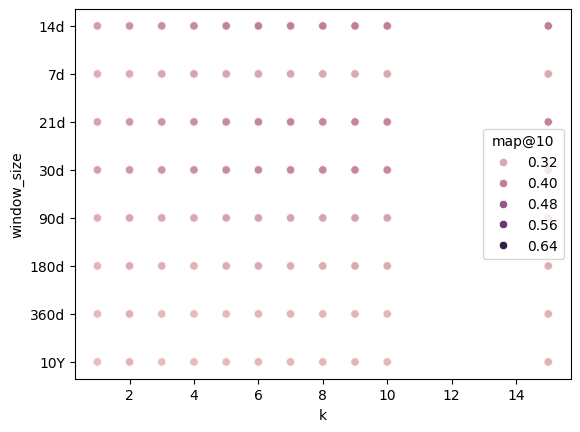

In [19]:
sns.scatterplot(mdfi, x='k', y='window_size', hue=_METRIC)

Text(0.5, 1.0, 'Results of multiple k sizes with ws=14d in itemknn')

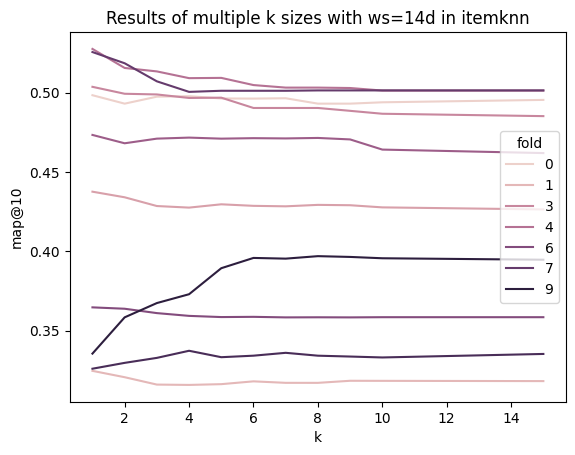

In [20]:
_WS = '14d'

sns.lineplot(mdfi[mdfi['window_size'] == _WS], x='k', y=_METRIC, hue='fold')
plt.title(f'Results of multiple k sizes with ws={_WS} in itemknn')

Cada fold tiene una mejor $k$, pero, ¿está esto relacionado con el número de propuestas abiertas o algo?

In [21]:
print("Choose the best k by fold", _METRIC)
_df = mdfi[mdfi['window_size'] == _WS].sort_values(_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', 'k'])[columns]
_df

Choose the best k by fold map@10


,,time,avg_recs,precision@5,precision@10,ndcg@5,ndcg@10,map@5,map@10,recall@5,recall@10,r-precision@5,r-precision@10
fold,k,,,,,,,,,,,,
0,1,0.017103,9.795918,0.285714,0.197959,0.364323,0.400360,0.466905,0.498433,0.568732,0.710398,0.759164,0.797215
1,1,0.002795,17.720000,0.321600,0.291200,0.250109,0.293177,0.289909,0.324614,0.262887,0.437241,0.500451,0.619004
2,1,0.002769,11.462366,0.264516,0.203226,0.347994,0.396146,0.409277,0.437601,0.456975,0.670176,0.678793,0.740604
3,1,0.002374,8.246753,0.368831,0.296104,0.359303,0.463572,0.406144,0.503720,0.523947,0.864974,0.657643,0.711178
4,1,0.005506,7.939024,0.365854,0.293902,0.363029,0.452544,0.445444,0.527624,0.590316,0.952947,0.650818,0.718775
5,1,0.001974,10.884615,0.333333,0.267949,0.279158,0.331144,0.425260,0.473385,0.496843,0.739228,0.698010,0.751046
6,1,0.002098,10.388350,0.227184,0.173786,0.259413,0.307719,0.323603,0.364652,0.437645,0.617599,0.694314,0.732228
7,1,0.001983,6.666667,0.330000,0.231667,0.293653,0.364538,0.448181,0.525654,0.670278,1.000000,0.748851,0.754598
8,4,0.003276,16.557143,0.264286,0.242857,0.198528,0.240918,0.296708,0.337280,0.314762,0.549426,0.493533,0.599950


Text(0.5, 1.0, 'Results of multiple window sizes with k=1')

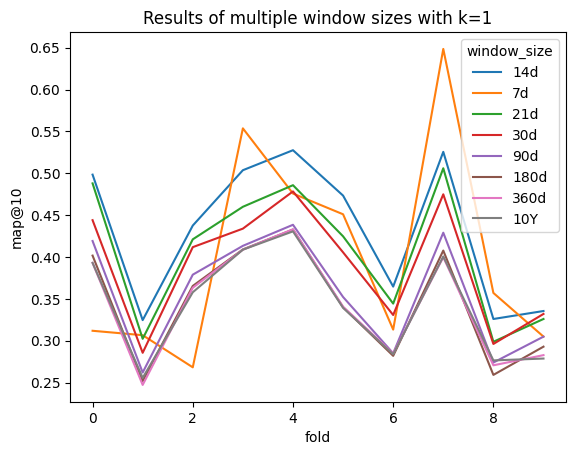

In [22]:
_K = 1

sns.lineplot(mdfi[mdfi['k'] == _K], x='fold', y=_METRIC, hue='window_size')
plt.title(f'Results of multiple window sizes with k={_K}')

## User-based KNN

In [23]:
from lenskit.algorithms import user_knn

In [24]:
def testHParamsUserKNN(fold, k: int, window_size=None):
    # Create algorithm
    algo = user_knn.UserUser(
        feedback='implicit', # VERY IMPORTANT
        min_sim=0,
        # min_nbrs=0,
        nnbrs=k,  # the maximum number of neighbors for scoring each item (None for unlimited)
    )
    return testHParamsLenskit(algo, fold, k, window_size)
    
testHParamsUserKNN(0, 5, '14d')

{'time': 0.6622532368637621,
 'open_proposals': 18,
 'min_recs': 1,
 'avg_recs': 9.795918367346939,
 'precision@1': 0.3877551020408163,
 'precision@3': 0.3537414965986394,
 'precision@5': 0.2938775510204081,
 'precision@10': 0.20306122448979594,
 'precision@100': 0.02612244897959184,
 'ndcg@1': 0.2733812949640288,
 'ndcg@3': 0.33338151448785663,
 'ndcg@5': 0.36852780397032137,
 'ndcg@10': 0.40542813611697004,
 'ndcg@100': 0.46453839976071437,
 'map@1': 0.3877551020408163,
 'map@3': 0.4367913832199546,
 'map@5': 0.46893140589569166,
 'map@10': 0.5027392135992719,
 'map@100': 0.5404862055029265,
 'recall@1': 0.18189990281827018,
 'recall@3': 0.47128279883381924,
 'recall@5': 0.5925534499514091,
 'recall@10': 0.7317784256559767,
 'recall@100': 1.0,
 'r-precision@1': 0.46911027568922303,
 'r-precision@3': 0.7486880466472303,
 'r-precision@5': 0.7670485175202155,
 'r-precision@10': 0.813162623539982,
 'r-precision@100': 0.813162623539982}

### Exploring hparams

In [25]:
results = explore_hparams(
    testHParamsUserKNN, 
    ParameterGrid({
    'fold': range(len(folds)),
    'k': [1,2,3,4,5,6,7,8,9,10,15], # ,20,25,30,35,40,45,50,60,70,80,90,100],
    'window_size': ['7d', '14d', '21d', '30d', '90d', '180d', '360d', '10Y'],
    }),
    paths.knn_progress('userknn', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, CUTOFF_DATE),
)
mdfu = pd.DataFrame(results)
mdfu

Restored checkpoint from data/knn/userknn-progress_Decentraland_W-THU_normalize-cutoff_date=2023-07-29 00:00:00.pickle with 880 results


  0%|          | 0/880 [00:00<?, ?it/s]

,fold,k,window_size,time,min_recs,avg_recs,precision@1,precision@3,precision@5,precision@10,...,recall@1,recall@3,recall@5,recall@10,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@100
0,0,1,7d,0.001051,3,12.038961,0.181818,0.285714,0.259740,0.209091,...,0.046877,0.338575,0.511534,0.803108,1.0,0.257823,0.447844,0.492669,0.534148,0.534148
1,0,1,14d,0.001685,1,9.795918,0.397959,0.363946,0.308163,0.210204,...,0.187852,0.483017,0.622413,0.758734,1.0,0.472039,0.732073,0.768452,0.814462,0.814462
2,0,1,21d,0.002500,1,10.269231,0.375000,0.339744,0.286538,0.207692,...,0.177976,0.466049,0.581433,0.771211,1.0,0.474603,0.739381,0.791071,0.830750,0.830750
3,0,1,30d,0.004370,1,11.068966,0.344828,0.327586,0.270690,0.188793,...,0.168391,0.449076,0.573225,0.732348,1.0,0.488333,0.742460,0.777673,0.812176,0.812176
4,0,1,90d,0.016667,1,11.767442,0.395349,0.294574,0.257364,0.183721,...,0.193103,0.396412,0.530938,0.679953,1.0,0.488436,0.726503,0.752543,0.773525,0.775929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,9,15,30d,0.002977,1,17.656863,0.245098,0.245098,0.239216,0.195098,...,0.114020,0.294134,0.456649,0.709160,1.0,0.465201,0.478298,0.561482,0.607267,0.634152
876,9,15,90d,0.010209,1,18.532787,0.262295,0.229508,0.221311,0.193443,...,0.104993,0.280662,0.456995,0.699512,1.0,0.400288,0.440017,0.494752,0.567326,0.595605
877,9,15,180d,0.028524,1,18.775194,0.193798,0.227390,0.209302,0.180620,...,0.083049,0.289285,0.421220,0.643948,1.0,0.428535,0.456355,0.514786,0.574018,0.604301
878,9,15,360d,0.054759,1,18.992647,0.250000,0.200980,0.191176,0.176471,...,0.127339,0.270128,0.380933,0.639398,1.0,0.509357,0.485878,0.527314,0.584939,0.613222


#### Table: Best overall hparams

In [26]:
columns = ['time'] + [ c for c in mdfu.columns if c.endswith('@5') or c.endswith('@10') ]

print("Best overall hyperparams")
mdfu.groupby(['window_size', 'k']).mean().sort_values('map@10', ascending=False)[columns]

Best overall hyperparams


time  precision@5  precision@10    ndcg@5   ndcg@10  \
window_size k                                                             
14d         1   0.001449     0.308928      0.246019  0.312405  0.374095   
            2   0.001441     0.307504      0.244518  0.306461  0.367300   
            3   0.001443     0.306711      0.244765  0.303515  0.364977   
7d          5   0.000972     0.302790      0.249711  0.248006  0.306002   
14d         4   0.001434     0.306582      0.244592  0.301709  0.363275   
...                  ...          ...           ...       ...       ...   
180d        10  0.033392     0.238478      0.208900  0.345641  0.443357   
360d        10  0.053001     0.236567      0.206593  0.353396  0.451455   
10Y         15  0.077979     0.234222      0.203368  0.356930  0.453469   
180d        15  0.033098     0.237377      0.206515  0.342310  0.434941   
360d        15  0.053226     0.234286      0.204864  0.346072  0.444021   

                   map@5    map@10  recall@5  recall@10  r-precision@5  \
window_size k                                                            
14d         1   0.397407  0.454806  0.507102   0.762594       0.635602   
            2   0.391324  0.446891  0.501864   0.753621       0.638940   
            3   0.387311  0.443848  0.497593   0.751313       0.636068   
7d          5   0.373722  0.441045  0.518530   0.793145       0.552313   
14d         4   0.384413  0.440934  0.497727   0.752155       0.639247   
...                  ...       ...       ...        ...            ...   
180d        10  0.301271  0.360465  0.400640   0.672859       0.614702   
360d        10  0.302063  0.358667  0.403049   0.670709       0.615013   
10Y         15  0.301927  0.356830  0.401171   0.662955       0.616015   
180d        15  0.298368  0.354579  0.400311   0.657886       0.612844   
360d        15  0.295539  0.352073  0.393130   0.662037       0.611137   

                r-precision@10  
window_size k                   
14d         1         0.700253  
            2         0.702810  
            3         0.703449  
7d          5         0.606461  
14d         4         0.707773  
...                        ...  
180d        10        0.681562  
360d        10        0.679279  
10Y         15        0.677310  
180d        15        0.680183  
360d        15        0.675081  

[88 rows x 11 columns]

#### Table: best hparams by fold

In [27]:
print("Best hyperparams by fold", _METRIC)
_df = mdfu.sort_values(_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', 'k', 'window_size'])[columns]
_df

Best hyperparams by fold map@10


,,,time,precision@5,precision@10,ndcg@5,ndcg@10,map@5,map@10,recall@5,recall@10,r-precision@5,r-precision@10
fold,k,window_size,,,,,,,,,,,
0,1,14d,0.001685,0.308163,0.210204,0.382514,0.418593,0.486749,0.520029,0.622413,0.758734,0.768452,0.814462
1,1,14d,0.001563,0.337600,0.304800,0.278922,0.324536,0.320940,0.353318,0.300316,0.502784,0.462033,0.587228
2,2,7d,0.001124,0.269333,0.210667,0.309065,0.362744,0.421974,0.476151,0.579365,0.819545,0.639739,0.687982
3,10,7d,0.000796,0.380328,0.321311,0.314138,0.401595,0.432354,0.545973,0.568604,0.905514,0.574066,0.619450
4,1,14d,0.001000,0.353659,0.293902,0.349846,0.447145,0.430230,0.518981,0.569396,0.949898,0.653950,0.729194
5,8,7d,0.000847,0.383607,0.290164,0.267261,0.307273,0.495264,0.555505,0.633997,0.868657,0.585595,0.639663
6,1,21d,0.001557,0.252252,0.184685,0.319211,0.372788,0.367182,0.406180,0.479688,0.687314,0.692720,0.738114
7,15,7d,0.000893,0.408889,0.224444,0.287196,0.305948,0.606235,0.629874,0.874074,1.000000,0.805556,0.805556
8,6,7d,0.001182,0.304762,0.278571,0.206710,0.257274,0.325683,0.386933,0.438445,0.725567,0.523715,0.630947


In [28]:
### Plotting some graphs

Text(0.5, 1.0, 'Results of multiple k sizes with ws=14d in userknn')

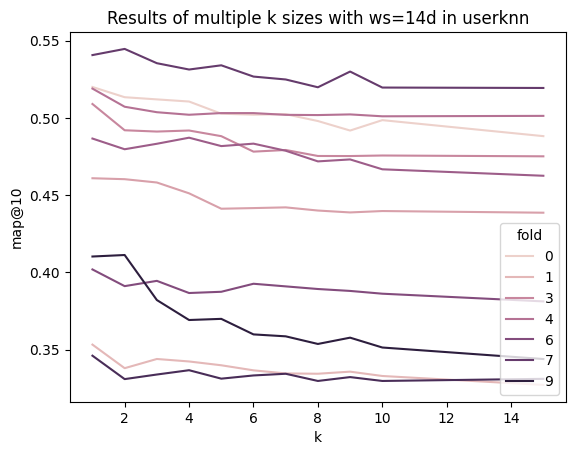

In [29]:
_WS = '14d'

sns.lineplot(mdfu[mdfu['window_size'] == _WS], x='k', y=_METRIC, hue='fold')
plt.title(f'Results of multiple k sizes with ws={_WS} in userknn')

Text(0.5, 1.0, 'Results of multiple window sizes with k=1 in uknn')

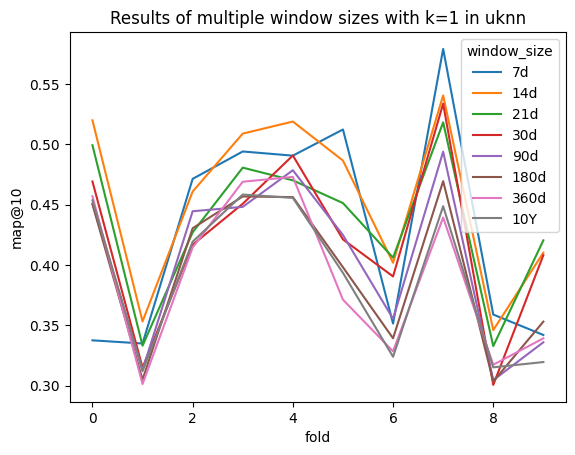

In [31]:
_K = 1

sns.lineplot(mdfu[mdfu['k'] == _K], x='fold', y=_METRIC, hue='window_size')
plt.title(f'Results of multiple window sizes with k={_K} in uknn')